## Part I

Download the dataset from HuggingFace

In [4]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 553.78it/s]


In [5]:
dataset.set_format("torch")
dataset.column_names

{'train': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'validation': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'test': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']}

In [8]:
import torch
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': tensor([22, 42, 16, 21, 35, 37, 16, 21,  7]),
 'chunk_tags': tensor([11, 21, 11, 12, 21, 22, 11, 12,  0]),
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

In [1]:
from datasets import load_dataset

dataset = load_dataset("conll2003")
dataset.set_format("torch", columns=["tokens", "ner_tags"])
dataset.column_names

/home/ronen/Documents/college/NNForNLP/workshop_1/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset conll2003 (/home/ronen/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)
100%|██████████| 3/3 [00:00<00:00, 50.91it/s]


{'train': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'validation': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
 'test': ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags']}

In [2]:
dataset['train'][0]

{'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': tensor([3, 0, 7, 0, 0, 0, 7, 0, 0])}

### EDA

In [5]:
# create a word count dictionary from training data
word_list = []
for row in dataset['train']:
    word_list.extend(row['tokens'])
from collections import Counter
import numpy as np
counter = Counter(np.array(word_list))
counter 

Counter({'EU': 24,
         'rejects': 1,
         'German': 85,
         'call': 30,
         'to': 3382,
         'boycott': 5,
         'British': 93,
         'lamb': 3,
         '.': 7374,
         'Peter': 31,
         'Blackburn': 11,
         'BRUSSELS': 17,
         '1996-08-22': 125,
         'The': 1127,
         'European': 86,
         'Commission': 49,
         'said': 1846,
         'on': 2040,
         'Thursday': 285,
         'it': 553,
         'disagreed': 2,
         'with': 840,
         'advice': 5,
         'consumers': 9,
         'shun': 1,
         'until': 53,
         'scientists': 6,
         'determine': 11,
         'whether': 45,
         'mad': 13,
         'cow': 12,
         'disease': 35,
         'can': 71,
         'be': 525,
         'transmitted': 2,
         'sheep': 12,
         'Germany': 143,
         "'s": 1536,
         'representative': 7,
         'the': 7243,
         'Union': 46,
         'veterinary': 8,
         'committee': 22,
    

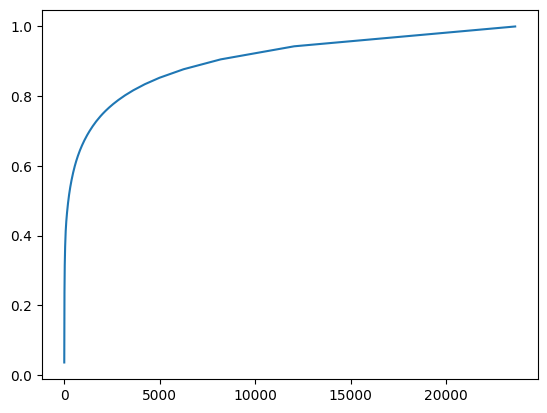

In [23]:
# sort counts by descending order and create a histogram of word covrege
counts = np.array(list(counter.values()))
counts = np.sort(counts)[::-1]
total_words = counts.sum()
counts = np.cumsum(counts)/total_words
from matplotlib import pyplot as plt
plt.plot(counts)
plt.show()

### Dataset

### Model

### Trainer

### Training

### Evaluation

### Metrics

## Part II

### Dataset


### Model

### Trainer

### Training

### Evaluation


### Metrics